<a href="https://colab.research.google.com/github/AndrewCrossman/Graduate_Research/blob/main/Find_CompProfile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [18]:
import csv
import numpy as np
import pandas as pd
import scipy as sp
from scipy import optimize
from google.colab import files
import matplotlib.pylab as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# 1D Composition Profile Plot

## Extract Data and Name Variables

In [86]:
# Experimental Data (RMC Reconstruction)
file = "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/Coreshell5050_AuPd_onAu/RMC_Coreshell5050_AuPd_onAu_4-10-5_v5/4-10.stru"
# Reference Data File (MC Target)
file_ref = "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/Coreshell5050_AuPd_onAu/MC_Coreshell5050_AuPd_onAu_r25_2000Cycles/2000_voidless.stru"
# Save file names

plotTitle = r'$Au_{50}Pd_{50}$: 4-10-5_v5'
plotsavename_by_atom = 'Au50Pd50_4-10-5_v5_CP_by_atom.png'
plotsavename_by_rad = 'Au50Pd50_4-10-5_v5_CP_by_rad.png'
plotsavename_by_rad_red = 'Au50Pd50_4-10-5_v5_CP_by_rad_red.png'
csvsavename_by_atom = 'Au50Pd50_4-10-5_v5_1D_CP_by_atom.csv'
csvsavename_by_rad = 'Au50Pd50_4-10-5_v5_1D_CP_by_rad.csv'
csvsavename_by_rad_red = 'Au50Pd50_4-10-5_v5_1D_CP_by_rad_red.csv'
# Reference Atoms
atom = 'AU'         # This atom has its composition profile measured
other_atom = 'PD'   # This atom is used for Labeling Purposes

In [87]:
################################################################################
# Extract Experimental Data (RMC)
################################################################################
data = pd.read_csv(file, skiprows=4)
data = data.drop(data.columns[3:], axis=1)
data[["atoms", "x"]] = data[data.columns[0]].str.split(expand=True)
data = data.drop(data.columns[0], axis=1)
data = data.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)
data = data[data.atom!='VOID']        # Removes all voids
data["x"] = data["x"].astype(float)
data["y"] = data["y"].astype(float)
data["z"] = data["z"].astype(float)
data["distance"] = np.sqrt((data["x"]*data["x"] + data["y"]*data["y"] + data["z"]*data["z"])*(4.0789*4.0789))
# Output relevant structural info
print("Max distance in angstroms "+str(round(data["distance"].max(),5)) +" - RMC Data")
print("Min distance in angstroms "+str(round(data["distance"].min(),5)) +" - RMC Data")
################################################################################
# Extract Reference Data (MMC)
################################################################################
data_ref = pd.read_csv(file_ref, skiprows=3)
data_ref = data_ref.drop(data_ref.columns[3:], axis=1)
data_ref[["atoms", "x"]] = data_ref[data_ref.columns[0]].str.split(expand=True)
data_ref = data_ref.drop(data_ref.columns[0], axis=1)
data_ref = data_ref.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)
data_ref = data_ref[data_ref.atom!='VOID']
data_ref["x"] = data_ref["x"].astype(float)
data_ref["y"] = data_ref["y"].astype(float)
data_ref["z"] = data_ref["z"].astype(float)
data_ref["distance"] = np.sqrt((data_ref["x"]*data_ref["x"] + data_ref["y"]*data_ref["y"] + data_ref["z"]*data_ref["z"])*(4.0789*4.0789))
# Output relevant structural info
print("Max distance in angstroms "+str(round(data_ref["distance"].max(),5)) +" - MC Ref")
print("Min distance in angstroms "+str(round(data_ref["distance"].min(),5)) +" - MC Ref")

<ipython-input-87-1961e0f0df39>:8: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  data = data.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)


Max distance in angstroms 28.04901 - RMC Data
Min distance in angstroms 0.09535 - RMC Data
Max distance in angstroms 25.19361 - MC Ref
Min distance in angstroms 0.09619 - MC Ref


<ipython-input-87-1961e0f0df39>:24: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  data_ref = data_ref.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)


### Bin Data by Similar Number of Atoms

In [88]:
################################################################################
# Bin Data between 0 and max distance in "numbin" divisions
################################################################################
# Make bins sizes based off of maximum radius
RMC_Bins = []
MMC_Bins = []
RMC_other_counts = []
RMC_atom_counts = []
MMC_other_counts = []
MMC_atom_counts = []
for i in range(25):
    RMC_temp = data.nsmallest(157*(i+1), "distance")[-157:]
    MMC_temp = data_ref.nsmallest(157*(i+1), "distance")[-157:]

    RMC_Bins.append(RMC_temp["distance"].mean())
    MMC_Bins.append(MMC_temp["distance"].mean())

    RMC_atom_count = len(RMC_temp[RMC_temp["atom"]==atom])
    RMC_other_count = len(RMC_temp[RMC_temp["atom"]!=atom])
    MMC_atom_count = len(MMC_temp[MMC_temp["atom"]==atom])
    MMC_other_count = len(MMC_temp[MMC_temp["atom"]!=atom])

    RMC_atom_counts.append(RMC_atom_count/(len(RMC_temp)))
    RMC_other_counts.append(RMC_other_count/(len(RMC_temp)))
    MMC_atom_counts.append(MMC_atom_count/(len(MMC_temp)))
    MMC_other_counts.append(MMC_other_count/(len(MMC_temp)))

### Bin Data by Radial Distance

In [89]:
################################################################################
# Bin Data between 0 and custom radial distance in "numbin" divisions
################################################################################
# Make bins sizes based off of custom max radius
numbin = 20

realBins_custom = np.around(np.linspace(0,26.15,numbin),decimals=2)

data["bin_custom"] = pd.cut(data["distance"], bins=realBins_custom, right=False, precision=2,include_lowest='True',labels=realBins_custom[1:])
data["bin_customn"] = data["bin_custom"].astype(float)
data_ref["bin_custom"] = pd.cut(data_ref["distance"], bins=realBins_custom, right=False, precision=2,include_lowest='True',labels=realBins_custom[1:])
data_ref["bin_custom"] = data_ref["bin_custom"].astype(float)
data = data[["atom","x","y","z","distance","bin_custom"]]
data_ref = data_ref[["atom","x","y","z","distance","bin_custom"]]
################################################################################
# Group atom type by bin in order to plot
################################################################################
data_grouped_custom = (data.groupby("bin_custom")["atom"].value_counts(normalize=True).unstack()).fillna(0)
data_ref_grouped_custom = (data_ref.groupby("bin_custom")["atom"].value_counts(normalize=True).unstack()).fillna(0)
################################################################################
# Output atom/bin grouping info to reference
################################################################################
print("RMC DATA")
print("BIN     #Atoms")
print(data.bin_custom.value_counts())
print("MC DATA")
print("BIN     #Atoms")
print(data_ref.bin_custom.value_counts())


RMC DATA
BIN     #Atoms
24.77    609
22.02    501
23.4     499
20.64    402
17.89    360
19.27    328
15.14    224
16.52    220
13.76    175
26.15    147
12.39    126
11.01    115
9.63      68
8.26      60
6.88      36
5.51      29
4.13      12
2.75       1
1.38       1
Name: bin_custom, dtype: int64
MC DATA
BIN     #Atoms
24.77    674
23.40    516
22.02    494
20.64    401
17.89    346
19.27    318
15.14    226
16.52    214
13.76    176
12.39    129
26.15    110
11.01    110
9.63      73
8.26      59
6.88      36
5.51      27
4.13      15
1.38       1
Name: bin_custom, dtype: int64


### Bin Data by Reduced Radial Distance

In [90]:
################################################################################
# Bin Data between 0 and max distance in "numbin" divisions
################################################################################
# Make bins sizes based off of custom max radius
numbin = 20

data["reduced_distance"] = data["distance"]*(1/np.percentile(data["distance"], 95))
data_ref["reduced_distance"] = data_ref["distance"]*(1/data_ref["distance"].max())

realBins_reduced = np.around(np.linspace(0,1,numbin),decimals=2)

data["bin_reduced"] = pd.cut(data["reduced_distance"], bins=realBins_reduced, right=False, precision=2,include_lowest='True',labels=realBins_reduced[1:])
data["bin_reduced"] = data["bin_reduced"].astype(float)
data_ref["bin_reduced"] = pd.cut(data_ref["reduced_distance"], bins=realBins_reduced, right=False, precision=2,include_lowest='True',labels=realBins_reduced[1:])
data_ref["bin_reduced"] = data_ref["bin_reduced"].astype(float)
data = data[["atom","x","y","z","distance","bin_custom","bin_reduced"]]
data_ref = data_ref[["atom","x","y","z","distance","bin_custom","bin_reduced"]]
################################################################################
# Group atom type by bin in order to plot
################################################################################
data_grouped_reduced = (data.groupby("bin_reduced")["atom"].value_counts(normalize=True).unstack()).fillna(0)
data_ref_grouped_reduced = (data_ref.groupby("bin_reduced")["atom"].value_counts(normalize=True).unstack()).fillna(0)
################################################################################
# Output atom/bin grouping info to reference
################################################################################
print("RMC DATA")
print("BIN     #Atoms")
print(data.bin_reduced.value_counts())
print("MC DATA")
print("BIN     #Atoms")
print(data_ref.bin_reduced.value_counts())

RMC DATA
BIN     #Atoms
1.00    554
0.95    543
0.89    440
0.79    366
0.74    348
0.84    330
0.63    261
0.68    205
0.53    173
0.58    136
0.47    118
0.32     76
0.42     73
0.37     45
0.21     29
0.26     17
0.16     12
0.05      1
Name: bin_reduced, dtype: int64
MC DATA
BIN     #Atoms
0.95    634
1.00    501
0.89    488
0.84    397
0.79    374
0.74    308
0.68    262
0.63    216
0.53    203
0.58    159
0.42    110
0.47     74
0.32     64
0.37     62
0.26     29
0.21     28
0.16     14
0.05      1
Name: bin_reduced, dtype: int64


## Make Composition Profile Plot

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

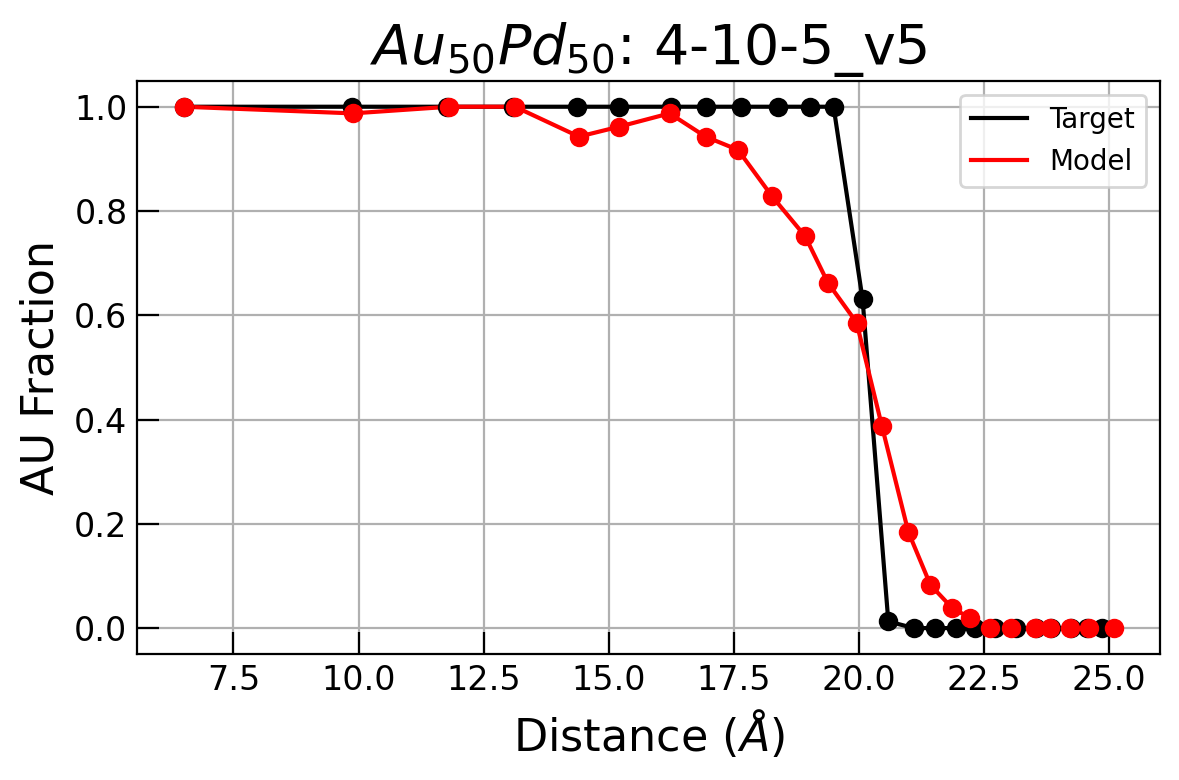

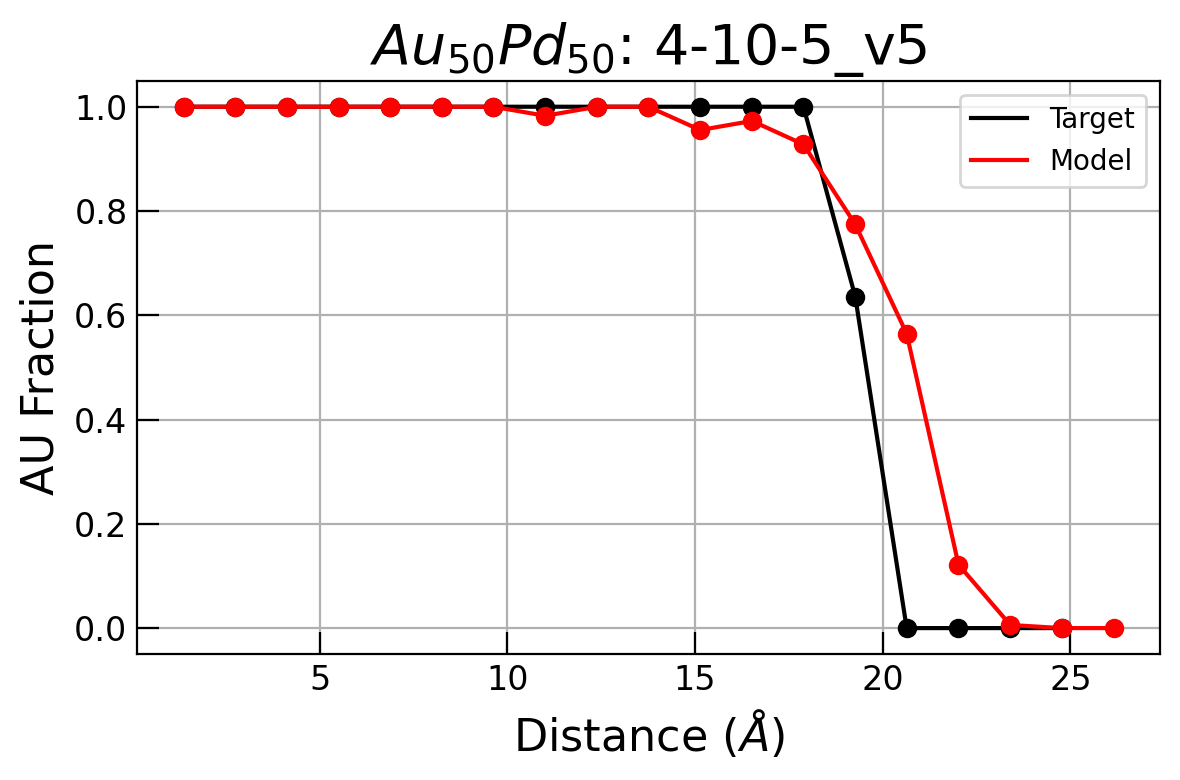

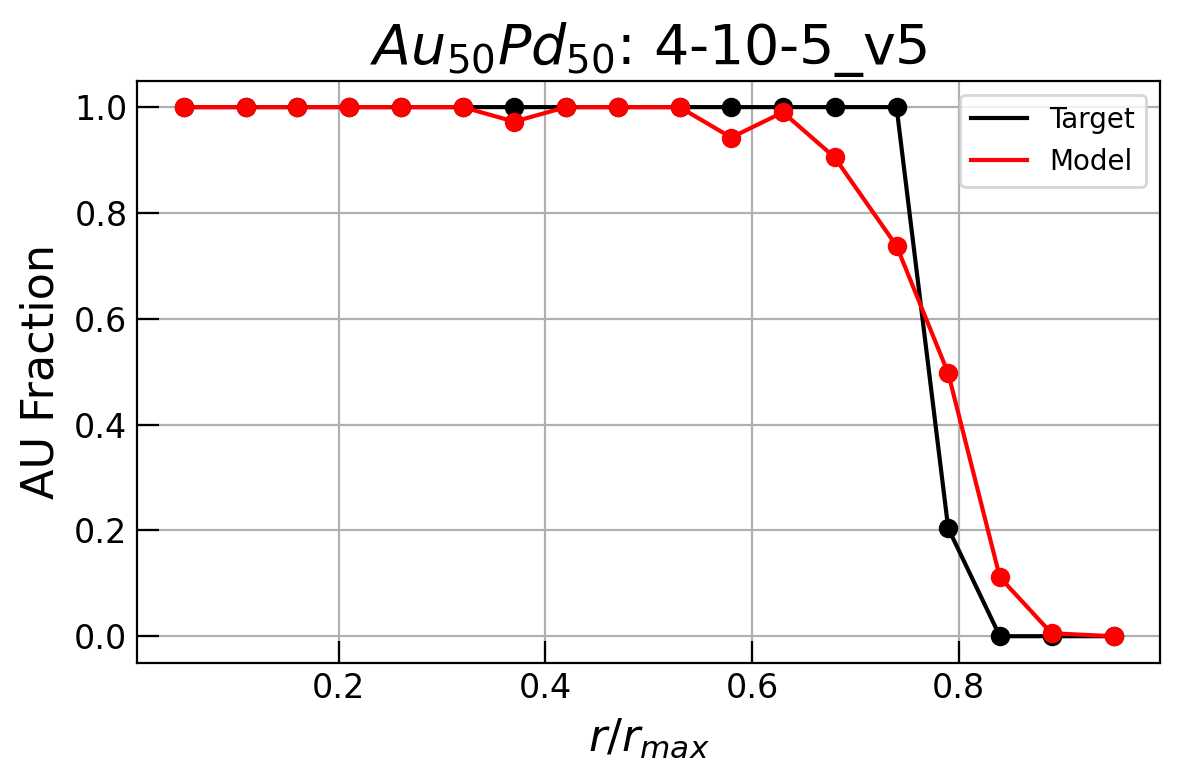

In [91]:
################################################################################
# Plot Data by Atom
################################################################################
fig1, ax1 = plt.subplots(figsize=(6,4,),dpi=200)
ax1.plot(MMC_Bins,MMC_atom_counts, color='black', label = "Target", zorder=1)
ax1.plot(RMC_Bins,RMC_atom_counts, color='red', label = "Model", zorder=1)
ax1.scatter(MMC_Bins,MMC_atom_counts, color='black', zorder=2)
ax1.scatter(RMC_Bins,RMC_atom_counts, color='red', zorder=2)
################################################################################
# Plot settings
################################################################################
ax1.set_title(plotTitle, fontsize=20)
ax1.set_ylabel(atom+" Fraction", fontsize=16)
ax1.tick_params(axis='y', labelsize=12, direction='in', length=8)
ax1.set_xlabel(r'Distance ($\AA$)', fontsize=16)
ax1.tick_params(axis='x', labelsize=12, direction='in', length=8)
ax1.legend()
ax1.grid(True)
ax1.set_axisbelow(True)
plt.tight_layout()
fig1.savefig(plotsavename_by_atom)
files.download(plotsavename_by_atom)
################################################################################
# Plot Data by Custom Radial Bins
################################################################################
fig2, ax2 = plt.subplots(figsize=(6,4,),dpi=200)
ax2.plot(realBins_custom[1:len(data_ref_grouped_custom[atom])+1],data_ref_grouped_custom[atom], color='black', label = "Target", zorder=1)
ax2.plot(realBins_custom[1:len(data_grouped_custom[atom])+1],data_grouped_custom[atom], color='red', label = "Model", zorder=1)
ax2.scatter(realBins_custom[1:len(data_ref_grouped_custom[atom])+1],data_ref_grouped_custom[atom], color='black', zorder=2)
ax2.scatter(realBins_custom[1:len(data_grouped_custom[atom])+1],data_grouped_custom[atom], color='red', zorder=2)
################################################################################
# Plot settings
################################################################################
ax2.set_title(plotTitle, fontsize=20)
ax2.set_ylabel(atom+" Fraction", fontsize=16)
ax2.tick_params(axis='y', labelsize=12, direction='in', length=8)
ax2.set_xlabel(r'Distance ($\AA$)', fontsize=16)
ax2.tick_params(axis='x', labelsize=12, direction='in', length=8)
ax2.legend()
ax2.grid(True)
ax2.set_axisbelow(True)
plt.tight_layout()
# Uncomment to save and download plots
fig2.savefig(plotsavename_by_rad)
files.download(plotsavename_by_rad)
################################################################################
# Plot Data by Reduced Distance
################################################################################
fig3, ax3 = plt.subplots(figsize=(6,4,),dpi=200)
ax3.plot(realBins_reduced[1:len(data_ref_grouped_reduced[atom])+1],data_ref_grouped_reduced[atom], color='black', label = "Target", zorder=1)
ax3.plot(realBins_reduced[1:len(data_grouped_reduced[atom])+1],data_grouped_reduced[atom], color='red', label = "Model", zorder=1)
ax3.scatter(realBins_reduced[1:len(data_ref_grouped_reduced[atom])+1],data_ref_grouped_reduced[atom], color='black', zorder=2)
ax3.scatter(realBins_reduced[1:len(data_grouped_reduced[atom])+1],data_grouped_reduced[atom], color='red', zorder=2)
################################################################################
# Plot settings
################################################################################
ax3.set_title(plotTitle, fontsize=20)
ax3.set_ylabel(atom+" Fraction", fontsize=16)
ax3.tick_params(axis='y', labelsize=12, direction='in', length=8)
ax3.set_xlabel(r'$r/r_{max}$', fontsize=16)
ax3.tick_params(axis='x', labelsize=12, direction='in', length=8)
ax3.legend()
ax3.grid(True)
ax3.set_axisbelow(True)
plt.tight_layout()
# Uncomment to save and download plots
fig3.savefig(plotsavename_by_rad_red)
files.download(plotsavename_by_rad_red)

## Output Data as a csv file

In [ ]:
# 4 new variables used for naming csv export file coulmn headers
csv_MMC_atom_counts = 'MMC_'+ atom +'_counts'
csv_MMC_other_atom_counts = 'MMC_'+ other_atom +'_counts'
csv_RMC_atom_counts = 'RMC_'+ atom +'_counts'
csv_RMC_other_atom_counts = 'RMC_'+ other_atom +'_counts'

column_values = ['RMC_Bins', csv_RMC_atom_counts, csv_RMC_other_atom_counts, 'MMC_Bins', csv_MMC_atom_counts, csv_MMC_other_atom_counts]
by_atom = pd.DataFrame(data = np.transpose([RMC_Bins, RMC_atom_counts, RMC_other_counts, MMC_Bins, MMC_atom_counts, MMC_other_counts]), columns = column_values)
by_atom

,RMC_Bins,RMC_PD_counts,RMC_NI_counts,MMC_Bins,MMC_PD_counts,MMC_NI_counts
0,6.315235,1.000000,0.000000,6.196565,1.000000,0.000000
1,9.653558,1.000000,0.000000,9.407427,1.000000,0.000000
2,11.446641,1.000000,0.000000,11.242150,1.000000,0.000000
3,12.750618,1.000000,0.000000,12.485247,1.000000,0.000000
4,13.936409,0.974522,0.025478,13.712459,1.000000,0.000000
5,14.828112,0.955414,0.044586,14.505015,1.000000,0.000000
6,15.723465,0.885350,0.114650,15.501664,1.000000,0.000000
7,16.471161,0.834395,0.165605,16.178426,1.000000,0.000000
8,17.109148,0.675159,0.324841,16.831753,1.000000,0.000000
9,17.783470,0.649682,0.350318,17.544297,1.000000,0.000000


In [ ]:
data_ref_grouped

atom,NI,PD
bin,,
1.86,0.000000,1.000000
3.71,0.000000,1.000000
5.57,0.000000,1.000000
7.43,0.000000,1.000000
9.29,0.000000,1.000000
11.14,0.000000,1.000000
13.00,0.000000,1.000000
14.86,0.000000,1.000000
16.71,0.000000,1.000000


In [ ]:
by_atom.to_csv(csvsavename_by_atom)
data_grouped_custom.to_csv(csvsavename_by_rad)
data_grouped_reduced.to_csv(csvsavename_by_rad_red)
files.download(csvsavename_by_atom)
files.download(csvsavename_by_rad)
files.download(csvsavename_by_rad_red)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 2D Composition Profile Plot

## Extract and Format Data

In [33]:
# 3D bin space
numbin = 25

In [35]:
################################################################################
# Extract RMC Data
################################################################################
RMC_data = pd.read_csv(file, skiprows=3)
RMC_data = RMC_data.drop(RMC_data.columns[3:], axis=1)
RMC_data[["atoms", "x"]] = RMC_data[RMC_data.columns[0]].str.split(expand=True)
RMC_data = RMC_data.drop(RMC_data.columns[0], axis=1)
RMC_data = RMC_data.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)
RMC_data = RMC_data[RMC_data.atom!='VOID']
################################################################################
# Format RMC Data
################################################################################
RMC_data["x"] = RMC_data["x"].astype(float)
RMC_data["y"] = RMC_data["y"].astype(float)
RMC_data["z"] = RMC_data["z"].astype(float)
RMC_data["distance"] = np.sqrt((RMC_data["x"]*RMC_data["x"] + RMC_data["y"]*RMC_data["y"] + RMC_data["z"]*RMC_data["z"]))
# Output relevant structural info
print("Max distance in angstroms "+str(round(RMC_data["distance"].max(),5)) +" - RMC Data")
print("Min distance in angstroms "+str(round(RMC_data["distance"].min(),5)) +" - RMC Data")
################################################################################
# Extract MMC Data
################################################################################
MMC_data = pd.read_csv(file_ref, skiprows=3)
MMC_data = MMC_data.drop(MMC_data.columns[3:], axis=1)
MMC_data[["atoms", "x"]] = MMC_data[MMC_data.columns[0]].str.split(expand=True)
MMC_data = MMC_data.drop(MMC_data.columns[0], axis=1)
MMC_data = MMC_data.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)
MMC_data = MMC_data[MMC_data.atom!='VOID']
################################################################################
# Format MMC Data
################################################################################
MMC_data["x"] = MMC_data["x"].astype(float)
MMC_data["y"] = MMC_data["y"].astype(float)
MMC_data["z"] = MMC_data["z"].astype(float)
MMC_data["distance"] = np.sqrt((MMC_data["x"]*MMC_data["x"] + MMC_data["y"]*MMC_data["y"] + MMC_data["z"]*MMC_data["z"]))
# Output relevant structural info
print("Max distance in angstroms "+str(round(MMC_data["distance"].max(),5)) +" - MMC Data")
print("Min distance in angstroms "+str(round(MMC_data["distance"].min(),5)) +" - MMC Data")

Max distance in angstroms 6.87661 - RMC Data
Min distance in angstroms 0.02338 - RMC Data
Max distance in angstroms 6.17657 - MMC Data
Min distance in angstroms 0.02358 - MMC Data


<ipython-input-35-0589896e5062>:8: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  RMC_data = RMC_data.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)
<ipython-input-35-0589896e5062>:27: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  MMC_data = MMC_data.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)


In [36]:
###############################################################################
# Bin Data
###############################################################################
realBins=[]
if RMC_data["distance"].max() > MMC_data["distance"].max():
  realBins = np.linspace(-1*RMC_data["distance"].max()-.01,RMC_data["distance"].max()+.01,numbin)
else:
  realBins = np.linspace(-1*MMC_data["distance"].max()-.01,MMC_data["distance"].max()+.01,numbin)

RMC_data["xbin"] = pd.cut(RMC_data["x"], bins=realBins, right=False, include_lowest='True',labels=realBins[1:]);
RMC_data["xbin"] = RMC_data["xbin"].astype(float);
RMC_data["ybin"] = pd.cut(RMC_data["y"], bins=realBins, right=False, include_lowest='True',labels=realBins[1:]);
RMC_data["ybin"] = RMC_data["ybin"].astype(float);
RMC_data["zbin"] = pd.cut(RMC_data["z"], bins=realBins, right=False, include_lowest='True',labels=realBins[1:]);
RMC_data["zbin"] = RMC_data["zbin"].astype(float);
RMC_data = RMC_data[["atom","x","y","z","distance","xbin","ybin","zbin"]]

MMC_data["xbin"] = pd.cut(MMC_data["x"], bins=realBins, right=False, include_lowest='True',labels=realBins[1:]);
MMC_data["xbin"] = MMC_data["xbin"].astype(float);
MMC_data["ybin"] = pd.cut(MMC_data["y"], bins=realBins, right=False, include_lowest='True',labels=realBins[1:]);
MMC_data["ybin"] = MMC_data["ybin"].astype(float);
MMC_data["zbin"] = pd.cut(MMC_data["z"], bins=realBins, right=False, include_lowest='True',labels=realBins[1:]);
MMC_data["zbin"] = MMC_data["zbin"].astype(float);
MMC_data = MMC_data[["atom","x","y","z","distance","xbin","ybin","zbin"]]

## Separate Data into 4 dataframes

In [37]:
RMC_data_atom = RMC_data[RMC_data["atom"] == atom]
RMC_data_other = RMC_data[RMC_data["atom"] != atom]
MMC_data_atom = MMC_data[MMC_data["atom"] == atom]
MMC_data_other = MMC_data[MMC_data["atom"] != atom]

### Convert Binned Data into 2D arrays (No slice through sphere)

In [38]:
MMC_atom_xy = np.zeros((numbin,numbin))
MMC_other_xy = np.zeros((numbin,numbin))
RMC_atom_xy = np.zeros((numbin,numbin))
RMC_other_xy = np.zeros((numbin,numbin))
MMC_atom_yz = np.zeros((numbin,numbin))
MMC_other_yz = np.zeros((numbin,numbin))
RMC_atom_yz = np.zeros((numbin,numbin))
RMC_other_yz = np.zeros((numbin,numbin))
MMC_atom_zx = np.zeros((numbin,numbin))
MMC_other_zx = np.zeros((numbin,numbin))
RMC_atom_zx = np.zeros((numbin,numbin))
RMC_other_zx = np.zeros((numbin,numbin))
x = 0
for i in realBins:
  y=0
  for j in realBins:
    try:
      MMC_atom_xy[x][y] = len(MMC_data_atom.loc[(MMC_data_atom["xbin"]==i) & (MMC_data_atom["ybin"]==j)])
      MMC_other_xy[x][y] = len(MMC_data_other.loc[(MMC_data_other["xbin"]==i) & (MMC_data_other["ybin"]==j)])
      RMC_atom_xy[x][y] = len(RMC_data_atom.loc[(RMC_data_atom["xbin"]==i) & (RMC_data_atom["ybin"]==j)])
      RMC_other_xy[x][y] = len(RMC_data_other.loc[(RMC_data_other["xbin"]==i) & (RMC_data_other["ybin"]==j)])

      MMC_atom_yz[x][y] = len(MMC_data_atom.loc[(MMC_data_atom["ybin"]==i) & (MMC_data_atom["zbin"]==j)])
      MMC_other_yz[x][y] = len(MMC_data_other.loc[(MMC_data_other["ybin"]==i) & (MMC_data_other["zbin"]==j)])
      RMC_atom_yz[x][y] = len(RMC_data_atom.loc[(RMC_data_atom["ybin"]==i) & (RMC_data_atom["zbin"]==j)])
      RMC_other_yz[x][y] = len(RMC_data_other.loc[(RMC_data_other["ybin"]==i) & (RMC_data_other["zbin"]==j)])

      MMC_atom_zx[x][y] = len(MMC_data_atom.loc[(MMC_data_atom["zbin"]==i) & (MMC_data_atom["xbin"]==j)])
      MMC_other_zx[x][y] = len(MMC_data_other.loc[(MMC_data_other["zbin"]==i) & (MMC_data_other["xbin"]==j)])
      RMC_atom_zx[x][y] = len(RMC_data_atom.loc[(RMC_data_atom["zbin"]==i) & (RMC_data_atom["xbin"]==j)])
      RMC_other_zx[x][y] = len(RMC_data_other.loc[(RMC_data_other["zbin"]==i) & (RMC_data_other["xbin"]==j)])
    except:
      None
    y+=1
  x+=1

In [39]:
diff_atom_xy = np.absolute(np.array(MMC_atom_xy) - np.array(RMC_atom_xy))
diff_atom_yz = np.absolute(np.array(MMC_atom_yz) - np.array(RMC_atom_yz))
diff_atom_zx = np.absolute(np.array(MMC_atom_zx) - np.array(RMC_atom_zx))

diff_other_xy = np.absolute(np.array(MMC_other_xy) - np.array(RMC_other_xy))
diff_other_yz = np.absolute(np.array(MMC_other_yz) - np.array(RMC_other_yz))
diff_other_zx = np.absolute(np.array(MMC_other_zx) - np.array(RMC_other_zx))

In [40]:
vmin = 0
vmax = np.array([MMC_atom_xy.max(), MMC_other_xy.max(), RMC_atom_xy.max(), RMC_other_xy.max(), MMC_atom_yz.max(), MMC_other_yz.max(),
                 RMC_atom_yz.max(), RMC_other_yz.max(), MMC_atom_zx.max(), MMC_other_zx.max(), RMC_atom_zx.max(), RMC_other_zx.max()]).max()
print(vmax)

29.0


### Plot Binned Data

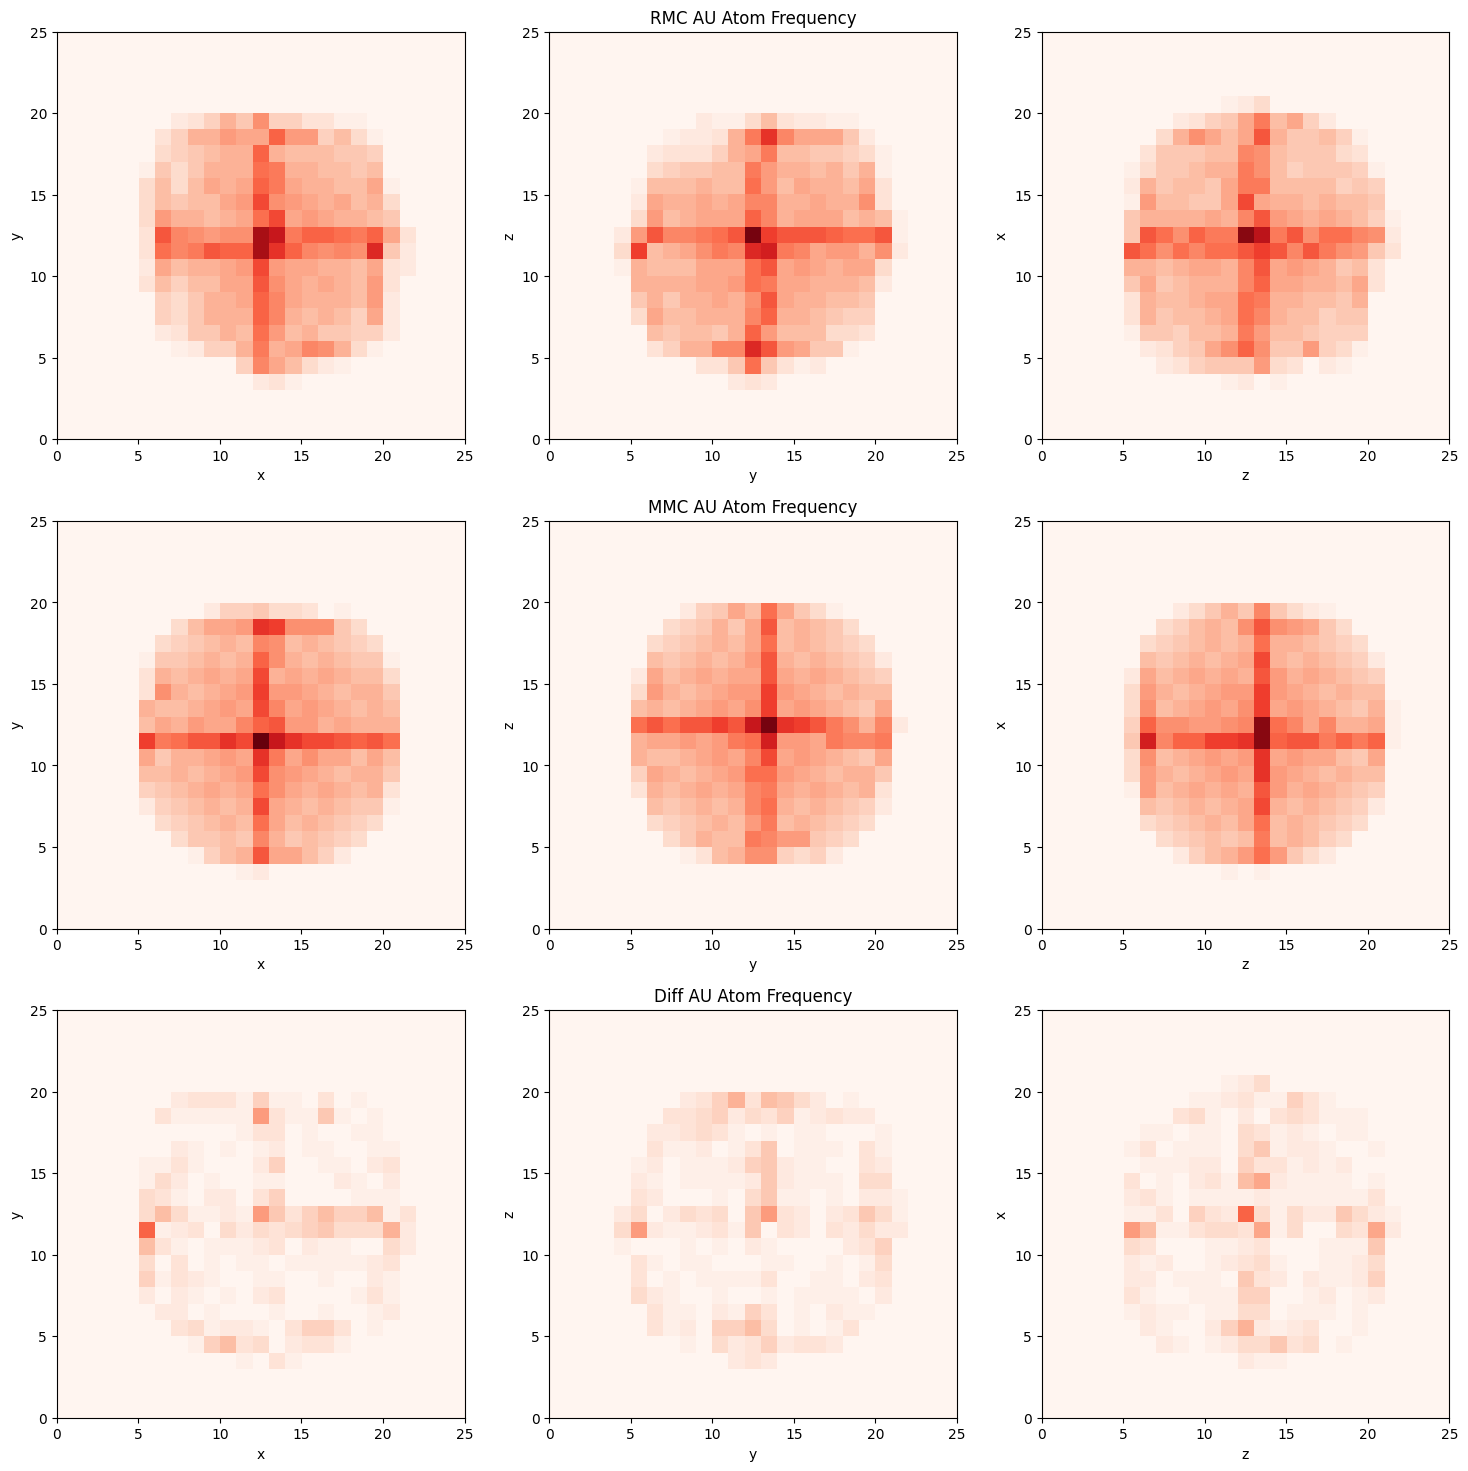

In [41]:
###############################################################################
fig, axs = plt.subplots(3, 3,figsize=(18, 18))
#fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(figsize=(18, 6), ncols=3, nrows=2)
#ax1.set_title("RMC Au Atom Frequency")
axs[0,0].set_xlabel("x")
axs[0,0].set_ylabel("y")
axs[0,0].imshow(RMC_atom_xy, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
axs[0,1].set_title("RMC "+atom+" Atom Frequency")
axs[0,1].set_xlabel("y")
axs[0,1].set_ylabel("z")
axs[0,1].imshow(RMC_atom_yz, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
#ax3.set_title("RMC Au Atom Frequency")
axs[0,2].set_xlabel("z")
axs[0,2].set_ylabel("x")
axs[0,2].imshow(RMC_atom_zx, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[1,0].set_xlabel("x")
axs[1,0].set_ylabel("y")
axs[1,0].imshow(MMC_atom_xy, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
axs[1,1].set_title("MMC "+atom+" Atom Frequency")
axs[1,1].set_xlabel("y")
axs[1,1].set_ylabel("z")
axs[1,1].imshow(MMC_atom_yz, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
#ax3.set_title("MMC Au Atom Frequency")
axs[1,2].set_xlabel("z")
axs[1,2].set_ylabel("x")
axs[1,2].imshow(MMC_atom_zx, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[2,0].set_xlabel("x")
axs[2,0].set_ylabel("y")
axs[2,0].imshow(diff_atom_xy, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
axs[2,1].set_title("Diff "+atom+" Atom Frequency")
axs[2,1].set_xlabel("y")
axs[2,1].set_ylabel("z")
axs[2,1].imshow(diff_atom_yz, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
#ax3.set_title("MMC Au Atom Frequency")
axs[2,2].set_xlabel("z")
axs[2,2].set_ylabel("x")
axs[2,2].imshow(diff_atom_zx, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")

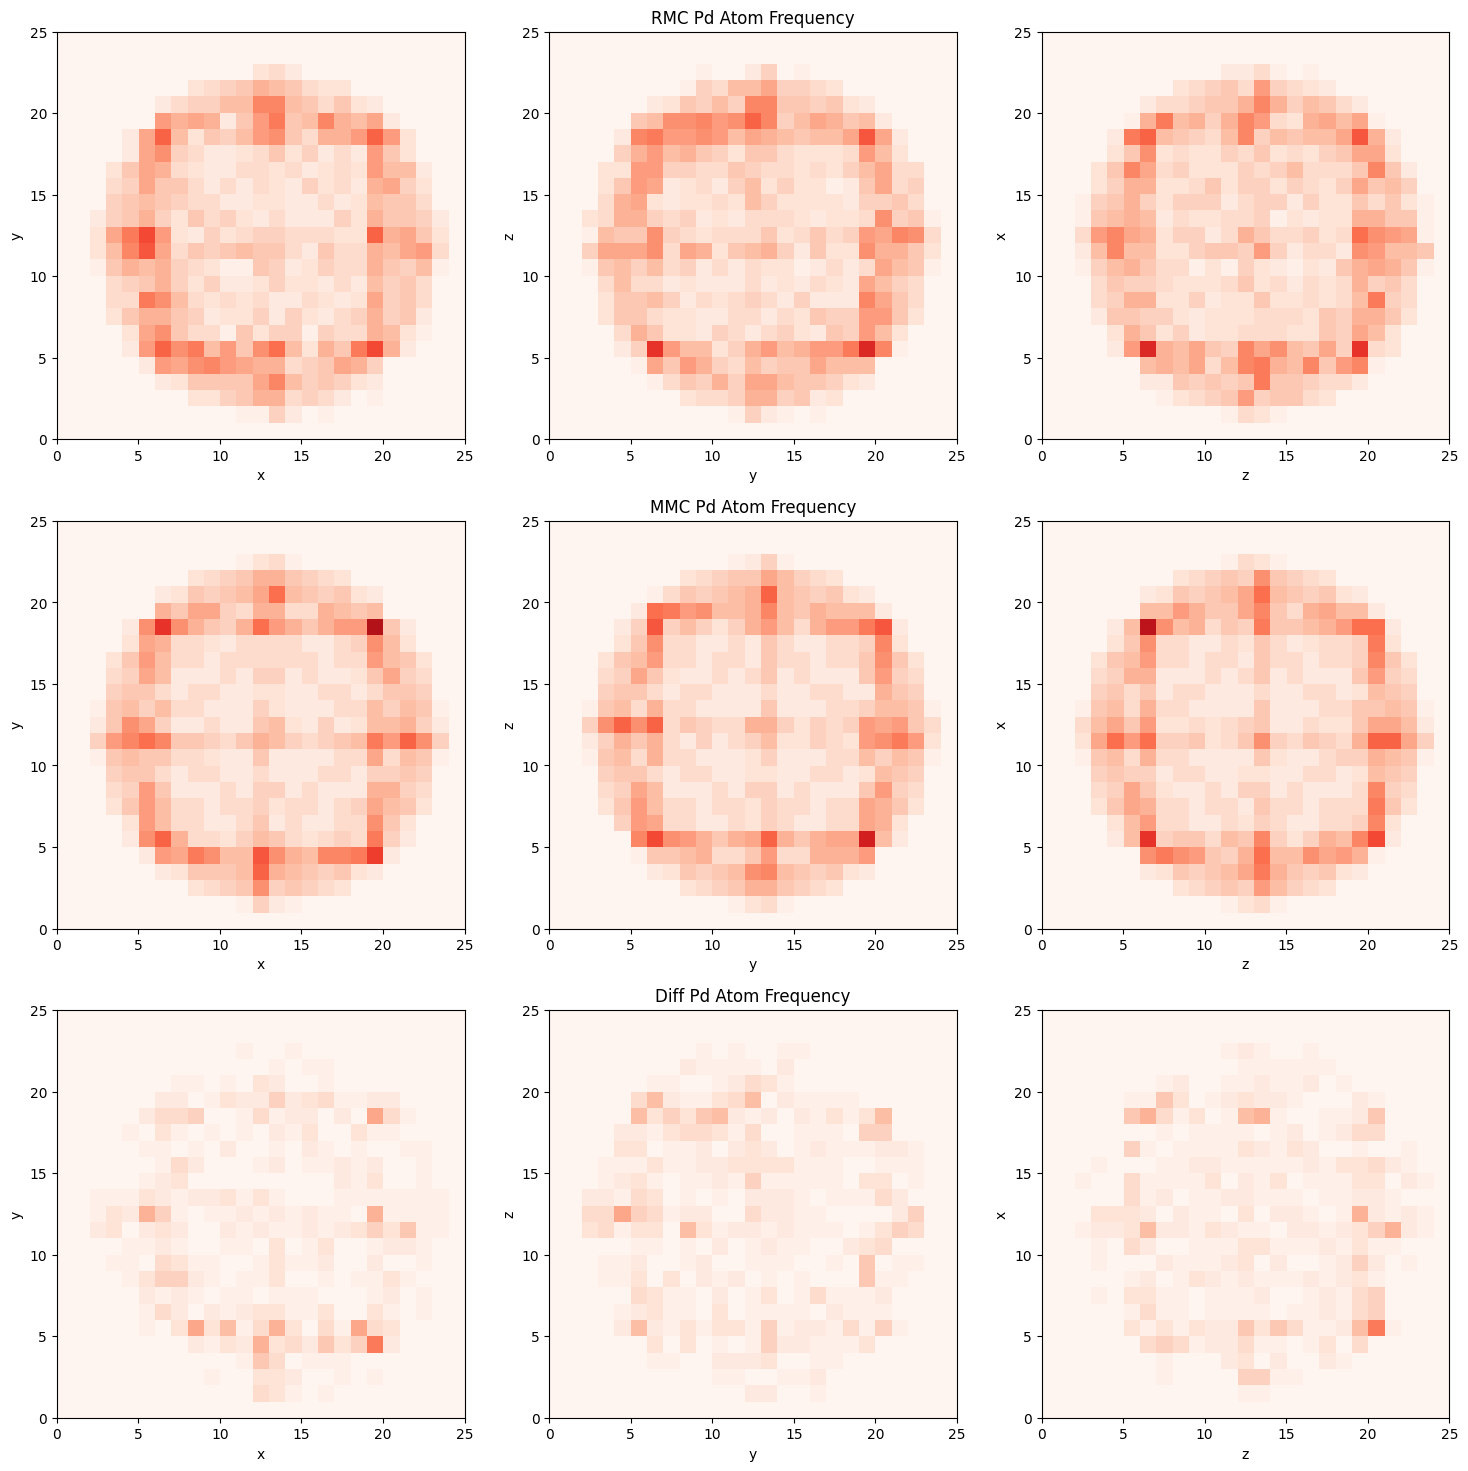

In [42]:
###############################################################################
fig, axs = plt.subplots(3, 3,figsize=(18, 18))
#fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(figsize=(18, 6), ncols=3, nrows=2)
#ax1.set_title("RMC Au Atom Frequency")
axs[0,0].set_xlabel("x")
axs[0,0].set_ylabel("y")
axs[0,0].imshow(RMC_other_xy, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
axs[0,1].set_title("RMC Pd Atom Frequency")
axs[0,1].set_xlabel("y")
axs[0,1].set_ylabel("z")
axs[0,1].imshow(RMC_other_yz, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
#ax3.set_title("RMC Au Atom Frequency")
axs[0,2].set_xlabel("z")
axs[0,2].set_ylabel("x")
axs[0,2].imshow(RMC_other_zx, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[1,0].set_xlabel("x")
axs[1,0].set_ylabel("y")
axs[1,0].imshow(MMC_other_xy, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
axs[1,1].set_title("MMC Pd Atom Frequency")
axs[1,1].set_xlabel("y")
axs[1,1].set_ylabel("z")
axs[1,1].imshow(MMC_other_yz, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
#ax3.set_title("MMC Au Atom Frequency")
axs[1,2].set_xlabel("z")
axs[1,2].set_ylabel("x")
axs[1,2].imshow(MMC_other_zx, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[2,0].set_xlabel("x")
axs[2,0].set_ylabel("y")
axs[2,0].imshow(diff_other_xy, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
axs[2,1].set_title("Diff Pd Atom Frequency")
axs[2,1].set_xlabel("y")
axs[2,1].set_ylabel("z")
axs[2,1].imshow(diff_other_yz, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
#ax3.set_title("MMC Au Atom Frequency")
axs[2,2].set_xlabel("z")
axs[2,2].set_ylabel("x")
axs[2,2].imshow(diff_other_zx, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")

### Convert Binned Data into 2D arrays (With Slice through sphere)

In [43]:
MMC_atom_xy = np.zeros((numbin,numbin))
MMC_other_xy = np.zeros((numbin,numbin))
RMC_atom_xy = np.zeros((numbin,numbin))
RMC_other_xy = np.zeros((numbin,numbin))
MMC_atom_yz = np.zeros((numbin,numbin))
MMC_other_yz = np.zeros((numbin,numbin))
RMC_atom_yz = np.zeros((numbin,numbin))
RMC_other_yz = np.zeros((numbin,numbin))
MMC_atom_zx = np.zeros((numbin,numbin))
MMC_other_zx = np.zeros((numbin,numbin))
RMC_atom_zx = np.zeros((numbin,numbin))
RMC_other_zx = np.zeros((numbin,numbin))
x = 0
for i in realBins:
  y=0
  for j in realBins:
    try:
      MMC_atom_xy[x][y] = len(MMC_data_atom.loc[(MMC_data_atom["xbin"]==i) & (MMC_data_atom["ybin"]==j) & (MMC_data_atom["zbin"]<1) & (MMC_data_atom["zbin"]>-1)])
      MMC_other_xy[x][y] = len(MMC_data_other.loc[(MMC_data_other["xbin"]==i) & (MMC_data_other["ybin"]==j) & (MMC_data_other["zbin"]<1) & (MMC_data_other["zbin"]>-1)])
      RMC_atom_xy[x][y] = len(RMC_data_atom.loc[(RMC_data_atom["xbin"]==i) & (RMC_data_atom["ybin"]==j) & (MMC_data_atom["zbin"]<1) & (MMC_data_atom["zbin"]>-1)])
      RMC_other_xy[x][y] = len(RMC_data_other.loc[(RMC_data_other["xbin"]==i) & (RMC_data_other["ybin"]==j) & (MMC_data_other["zbin"]<1) & (MMC_data_other["zbin"]>-1)])

      MMC_atom_yz[x][y] = len(MMC_data_atom.loc[(MMC_data_atom["ybin"]==i) & (MMC_data_atom["zbin"]==j) & (MMC_data_atom["xbin"]<1) & (MMC_data_atom["xbin"]>-1)])
      MMC_other_yz[x][y] = len(MMC_data_other.loc[(MMC_data_other["ybin"]==i) & (MMC_data_other["zbin"]==j) & (MMC_data_other["xbin"]<1) & (MMC_data_other["xbin"]>-1)])
      RMC_atom_yz[x][y] = len(RMC_data_atom.loc[(RMC_data_atom["ybin"]==i) & (RMC_data_atom["zbin"]==j) & (MMC_data_atom["xbin"]<1) & (MMC_data_atom["xbin"]>-1)])
      RMC_other_yz[x][y] = len(RMC_data_other.loc[(RMC_data_other["ybin"]==i) & (RMC_data_other["zbin"]==j) & (MMC_data_other["xbin"]<1) & (MMC_data_other["xbin"]>-1)])

      MMC_atom_zx[x][y] = len(MMC_data_atom.loc[(MMC_data_atom["zbin"]==i) & (MMC_data_atom["xbin"]==j) & (MMC_data_atom["ybin"]<1) & (MMC_data_atom["ybin"]>-1)])
      MMC_other_zx[x][y] = len(MMC_data_other.loc[(MMC_data_other["zbin"]==i) & (MMC_data_other["xbin"]==j) & (MMC_data_other["ybin"]<1) & (MMC_data_other["ybin"]>-1)])
      RMC_atom_zx[x][y] = len(RMC_data_atom.loc[(RMC_data_atom["zbin"]==i) & (RMC_data_atom["xbin"]==j) & (MMC_data_atom["ybin"]<1) & (MMC_data_atom["ybin"]>-1)])
      RMC_other_zx[x][y] = len(RMC_data_other.loc[(RMC_data_other["zbin"]==i) & (RMC_data_other["xbin"]==j) & (MMC_data_other["ybin"]<1) & (MMC_data_other["ybin"]>-1)])
    except:
      None
    y+=1
  x+=1

In [44]:
diff_atom_xy = np.absolute(np.array(MMC_atom_xy) - np.array(RMC_atom_xy))
diff_atom_yz = np.absolute(np.array(MMC_atom_yz) - np.array(RMC_atom_yz))
diff_atom_zx = np.absolute(np.array(MMC_atom_zx) - np.array(RMC_atom_zx))

diff_other_xy = np.absolute(np.array(MMC_other_xy) - np.array(RMC_other_xy))
diff_other_yz = np.absolute(np.array(MMC_other_yz) - np.array(RMC_other_yz))
diff_other_zx = np.absolute(np.array(MMC_other_zx) - np.array(RMC_other_zx))

In [45]:
vmin = 0
vmax = np.array([MMC_atom_xy.max(), MMC_other_xy.max(), RMC_atom_xy.max(), RMC_other_xy.max(),
                 MMC_atom_yz.max(),MMC_other_yz.max(), RMC_atom_yz.max(), RMC_other_yz.max(),
                 MMC_atom_zx.max(), MMC_other_zx.max(), RMC_atom_zx.max(), RMC_other_zx.max()]).max()
print(vmax)

8.0


### Plot Binned Data (Frequency Plots)

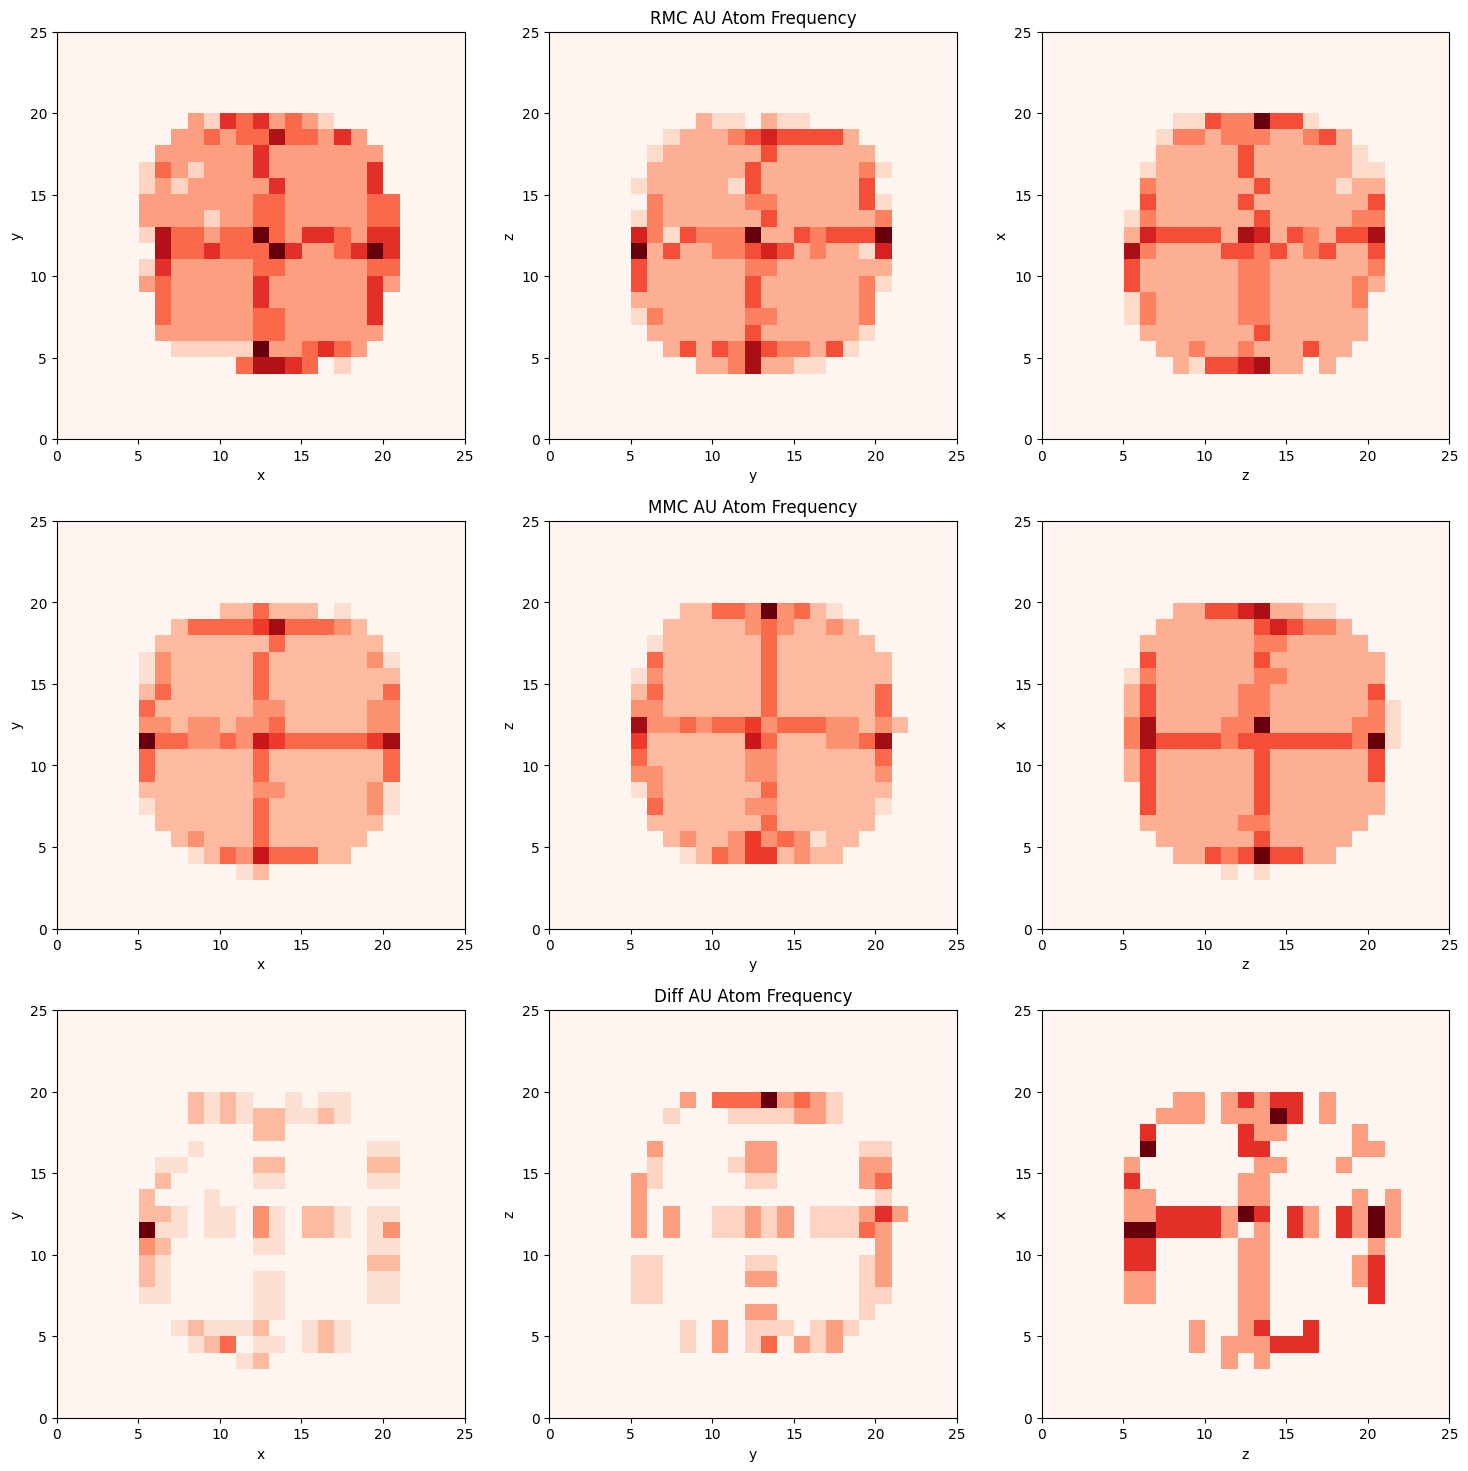

In [46]:
###############################################################################
fig, axs = plt.subplots(3, 3,figsize=(18, 18))
#fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(figsize=(18, 6), ncols=3, nrows=2)
#ax1.set_title("RMC Au Atom Frequency")
axs[0,0].set_xlabel("x")
axs[0,0].set_ylabel("y")
axs[0,0].imshow(RMC_atom_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
axs[0,1].set_title("RMC "+atom+" Atom Frequency")
axs[0,1].set_xlabel("y")
axs[0,1].set_ylabel("z")
axs[0,1].imshow(RMC_atom_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
#ax3.set_title("RMC Au Atom Frequency")
axs[0,2].set_xlabel("z")
axs[0,2].set_ylabel("x")
axs[0,2].imshow(RMC_atom_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[1,0].set_xlabel("x")
axs[1,0].set_ylabel("y")
axs[1,0].imshow(MMC_atom_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
axs[1,1].set_title("MMC "+atom+" Atom Frequency")
axs[1,1].set_xlabel("y")
axs[1,1].set_ylabel("z")
axs[1,1].imshow(MMC_atom_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
#ax3.set_title("MMC Au Atom Frequency")
axs[1,2].set_xlabel("z")
axs[1,2].set_ylabel("x")
axs[1,2].imshow(MMC_atom_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[2,0].set_xlabel("x")
axs[2,0].set_ylabel("y")
axs[2,0].imshow(diff_atom_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
axs[2,1].set_title("Diff "+atom+" Atom Frequency")
axs[2,1].set_xlabel("y")
axs[2,1].set_ylabel("z")
axs[2,1].imshow(diff_atom_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
#ax3.set_title("MMC Au Atom Frequency")
axs[2,2].set_xlabel("z")
axs[2,2].set_ylabel("x")
axs[2,2].imshow(diff_atom_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")

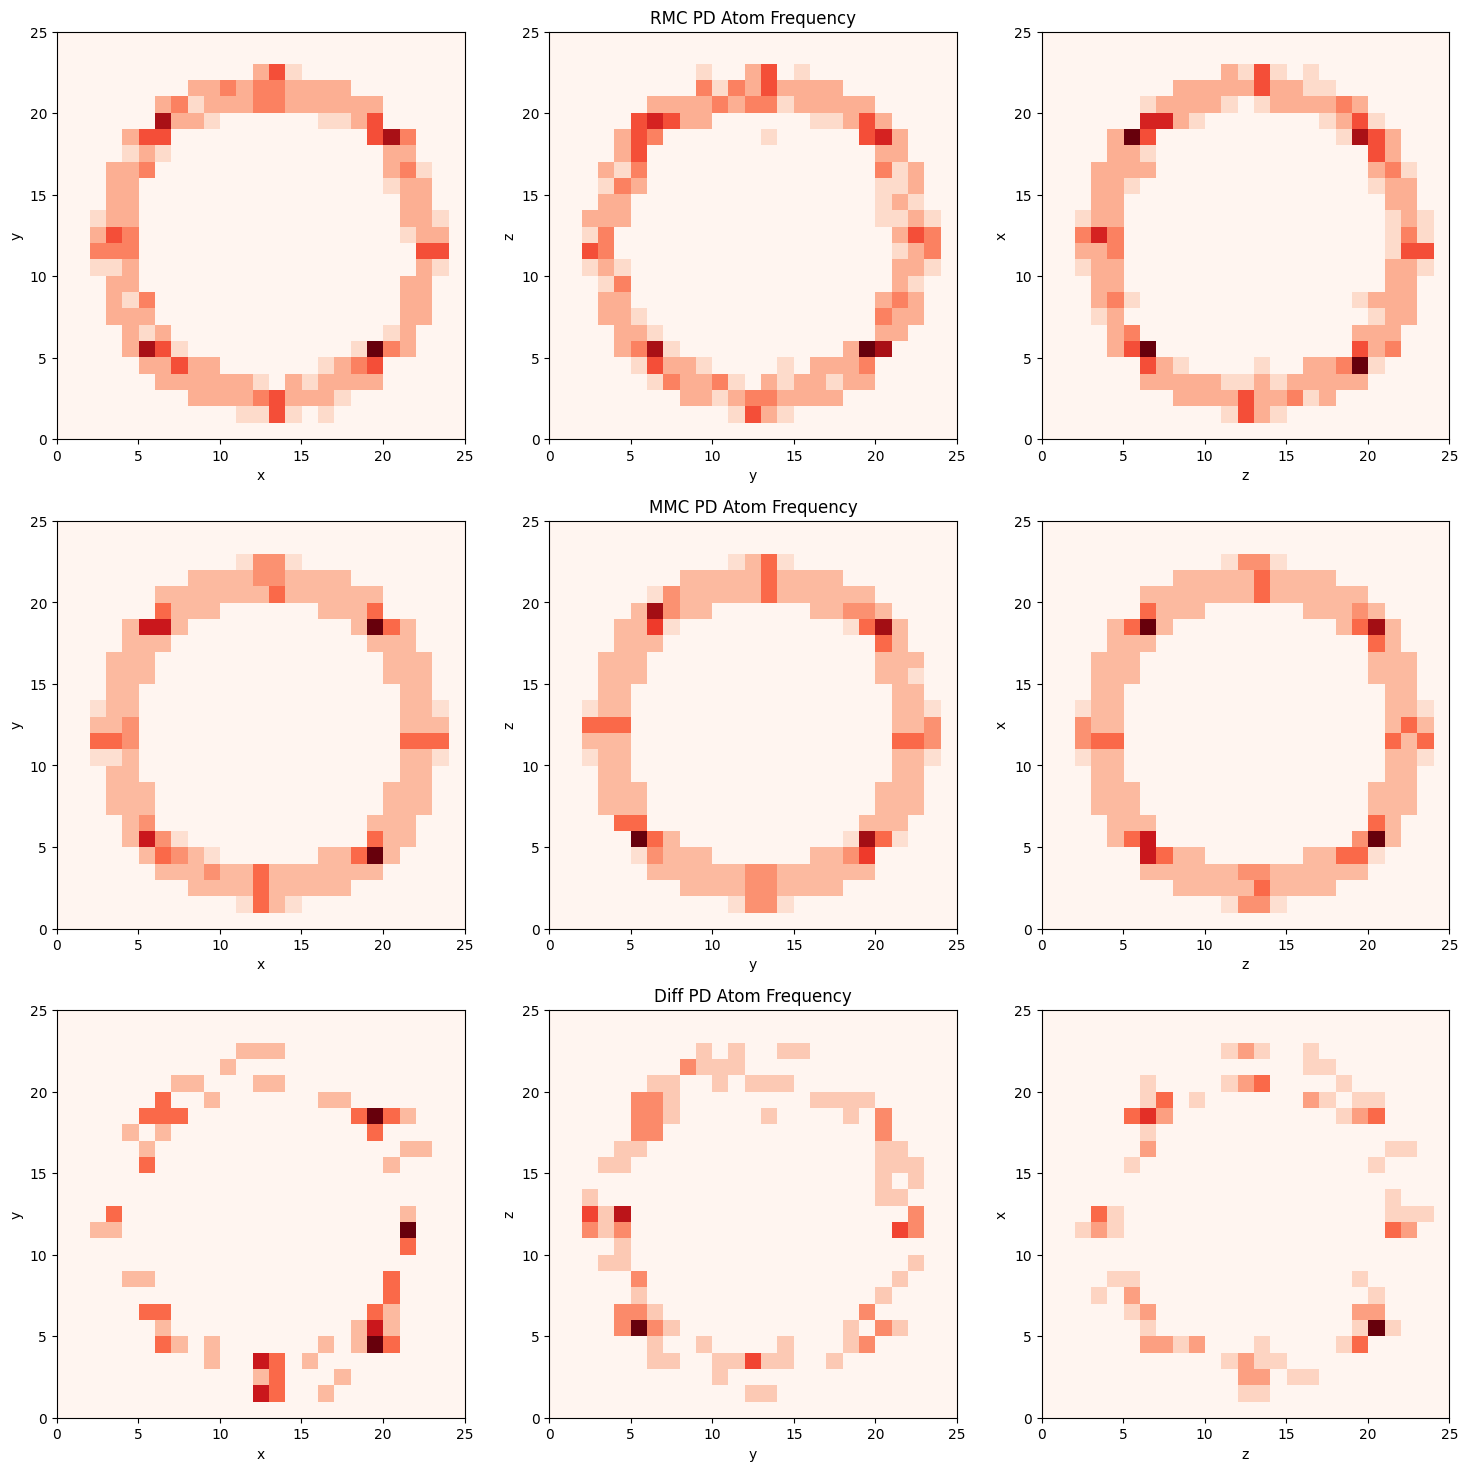

In [47]:
###############################################################################
fig, axs = plt.subplots(3, 3,figsize=(18, 18))
#fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(figsize=(18, 6), ncols=3, nrows=2)
#ax1.set_title("RMC Au Atom Frequency")
axs[0,0].set_xlabel("x")
axs[0,0].set_ylabel("y")
axs[0,0].imshow(RMC_other_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
axs[0,1].set_title("RMC "+other_atom+" Atom Frequency")
axs[0,1].set_xlabel("y")
axs[0,1].set_ylabel("z")
axs[0,1].imshow(RMC_other_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
#ax3.set_title("RMC Au Atom Frequency")
axs[0,2].set_xlabel("z")
axs[0,2].set_ylabel("x")
axs[0,2].imshow(RMC_other_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[1,0].set_xlabel("x")
axs[1,0].set_ylabel("y")
axs[1,0].imshow(MMC_other_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
axs[1,1].set_title("MMC "+other_atom+" Atom Frequency")
axs[1,1].set_xlabel("y")
axs[1,1].set_ylabel("z")
axs[1,1].imshow(MMC_other_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
#ax3.set_title("MMC Au Atom Frequency")
axs[1,2].set_xlabel("z")
axs[1,2].set_ylabel("x")
axs[1,2].imshow(MMC_other_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[2,0].set_xlabel("x")
axs[2,0].set_ylabel("y")
axs[2,0].imshow(diff_other_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
axs[2,1].set_title("Diff "+other_atom+" Atom Frequency")
axs[2,1].set_xlabel("y")
axs[2,1].set_ylabel("z")
axs[2,1].imshow(diff_other_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
#ax3.set_title("MMC Au Atom Frequency")
axs[2,2].set_xlabel("z")
axs[2,2].set_ylabel("x")
axs[2,2].imshow(diff_other_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")

## 2D Composition Plot

Indicates the composition of the reconstructed sphere through the volume that each 2D bin corresponds to

### Convert Binned Data ino 2D Arrays

In [48]:
###############################################################################
# Format's Data into arrays that contain the Au fraction in the appropriate
# channel/bin then normalizes about 0. (i.e. -.5 means all Pd whereas +.5 means all Au)
###############################################################################
MMC_xy = np.zeros((numbin,numbin))
RMC_xy = np.zeros((numbin,numbin))
MMC_yz = np.zeros((numbin,numbin))
RMC_yz = np.zeros((numbin,numbin))
MMC_zx = np.zeros((numbin,numbin))
RMC_zx = np.zeros((numbin,numbin))
x = 0
for i in realBins:
  y=0
  for j in realBins:
    try:
      MMC_xy[x][y] = len(MMC_data.loc[(MMC_data["xbin"]==i) & (MMC_data["ybin"]==j) & (MMC_data["atom"]==atom)]) / len(MMC_data.loc[(MMC_data["xbin"]==i) & (MMC_data["ybin"]==j)])-0.5
      RMC_xy[x][y] = len(RMC_data.loc[(RMC_data["xbin"]==i) & (RMC_data["ybin"]==j) & (RMC_data["atom"]==atom)]) / len(RMC_data.loc[(RMC_data["xbin"]==i) & (RMC_data["ybin"]==j)])-0.5

      MMC_yz[x][y] = len(MMC_data.loc[(MMC_data["ybin"]==i) & (MMC_data["zbin"]==j) & (MMC_data["atom"]==atom)]) / len(MMC_data.loc[(MMC_data["ybin"]==i) & (MMC_data["zbin"]==j)])-0.5
      RMC_yz[x][y] = len(RMC_data.loc[(RMC_data["ybin"]==i) & (RMC_data["zbin"]==j) & (RMC_data["atom"]==atom)]) / len(RMC_data.loc[(RMC_data["ybin"]==i) & (RMC_data["zbin"]==j)])-0.5

      MMC_zx[x][y] = len(MMC_data.loc[(MMC_data["zbin"]==i) & (MMC_data["xbin"]==j) & (MMC_data["atom"]==atom)]) / len(MMC_data.loc[(MMC_data["zbin"]==i) & (MMC_data["xbin"]==j)])-0.5
      RMC_zx[x][y] = len(RMC_data.loc[(RMC_data["zbin"]==i) & (RMC_data["xbin"]==j) & (RMC_data["atom"]==atom)]) / len(RMC_data.loc[(RMC_data["zbin"]==i) & (RMC_data["xbin"]==j)])-0.5
    except:
      None
    y+=1
  x+=1
###############################################################################
# Finds the difference between the RMC and MMC Au fractions
###############################################################################
diff_xy = (np.array(MMC_xy) - np.array(RMC_xy))
diff_yz = (np.array(MMC_yz) - np.array(RMC_yz))
diff_zx =(np.array(MMC_zx) - np.array(RMC_zx))

diff_xy = (np.array(MMC_xy) - np.array(RMC_xy))
diff_yz = (np.array(MMC_yz) - np.array(RMC_yz))
diff_zx =(np.array(MMC_zx) - np.array(RMC_zx))

### Plot Binned Data

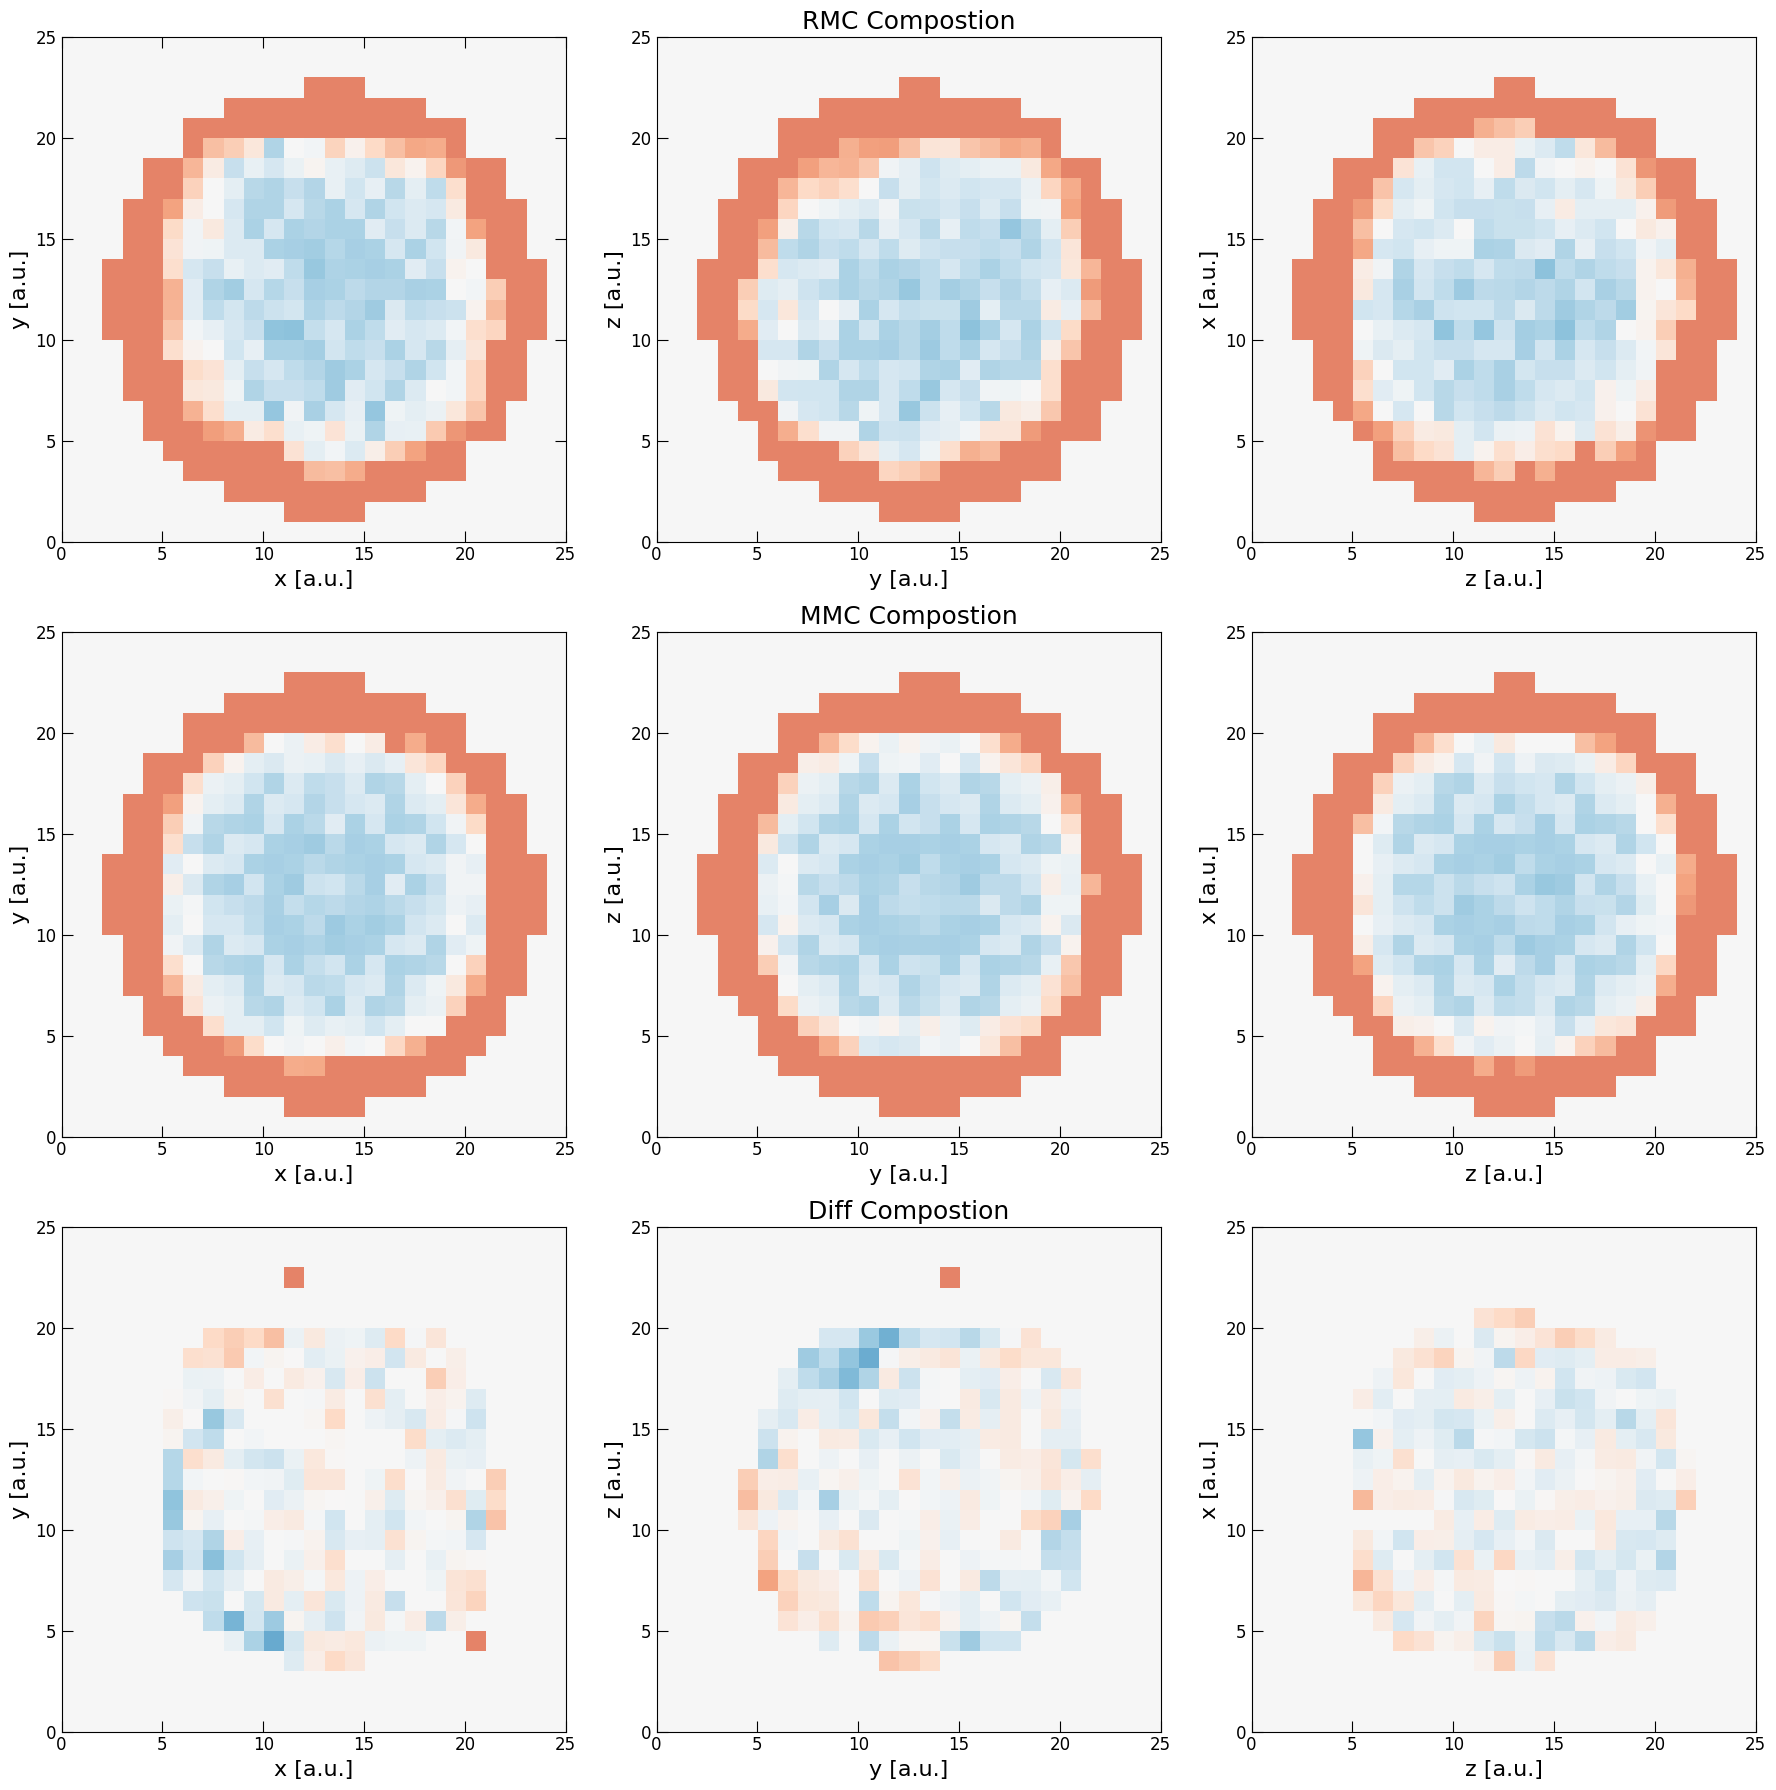

In [49]:
###############################################################################
fig, axs = plt.subplots(3, 3,figsize=(18, 18))
###
#ax1.set_title("RMC Au Atom Frequency")
axs[0,0].set_xlabel("x [a.u.]", fontsize=16)
axs[0,0].set_ylabel("y [a.u.]", fontsize=16)
axs[0,0].tick_params(bottom=True, top=True, left=True, right=True)
axs[0,0].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[0,0].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[0,0].imshow(RMC_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
###
axs[0,1].set_title("RMC Compostion", fontsize=18)
axs[0,1].set_xlabel("y [a.u.]", fontsize=16)
axs[0,1].set_ylabel("z [a.u.]", fontsize=16)
axs[0,1].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[0,1].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[0,1].imshow(RMC_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
###
#ax3.set_title("RMC Au Atom Frequency")
axs[0,2].set_xlabel("z [a.u.]", fontsize=16)
axs[0,2].set_ylabel("x [a.u.]", fontsize=16)
axs[0,2].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[0,2].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[0,2].imshow(RMC_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))

###
#axs[1,0].set_title("MMC Au Atom Frequency")
axs[1,0].set_xlabel("x [a.u.]", fontsize=16)
axs[1,0].set_ylabel("y [a.u.]", fontsize=16)
axs[1,0].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[1,0].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[1,0].imshow(MMC_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
###
axs[1,1].set_title("MMC Compostion", fontsize=18)
axs[1,1].set_xlabel("y [a.u.]", fontsize=16)
axs[1,1].set_ylabel("z [a.u.]", fontsize=16)
axs[1,1].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[1,1].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[1,1].imshow(MMC_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
###
#ax3.set_title("MMC Au Atom Frequency")
axs[1,2].set_xlabel("z [a.u.]", fontsize=16)
axs[1,2].set_ylabel("x [a.u.]", fontsize=16)
axs[1,2].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[1,2].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[1,2].imshow(MMC_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))

###
#axs[1,0].set_title("MMC Au Atom Frequency")
axs[2,0].set_xlabel("x [a.u.]", fontsize=16)
axs[2,0].set_ylabel("y [a.u.]", fontsize=16)
axs[2,0].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[2,0].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[2,0].imshow(diff_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
###
axs[2,1].set_title("Diff Compostion", fontsize=18)
axs[2,1].set_xlabel("y [a.u.]", fontsize=16)
axs[2,1].set_ylabel("z [a.u.]", fontsize=16)
axs[2,1].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[2,1].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[2,1].imshow(diff_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
###
#ax3.set_title("MMC Au Atom Frequency")
axs[2,2].set_xlabel("z [a.u.]", fontsize=16)
axs[2,2].set_ylabel("x [a.u.]", fontsize=16)
axs[2,2].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[2,2].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[2,2].imshow(diff_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
plt.tight_layout()

## 2D Composition Plot of Slice

### Convert Binned Data into 2D Arrays

In [50]:
###############################################################################
# Format's Data into arrays that contain the Au fraction in the appropriate
# channel/bin then normalizes about 0. (i.e. -.5 means all Pd whereas +.5 means all Au)
###############################################################################
MMC_xy = np.zeros((numbin,numbin))
RMC_xy = np.zeros((numbin,numbin))
MMC_yz = np.zeros((numbin,numbin))
RMC_yz = np.zeros((numbin,numbin))
MMC_zx = np.zeros((numbin,numbin))
RMC_zx = np.zeros((numbin,numbin))
x = 0
for i in realBins:
  y=0
  for j in realBins:
    try:
      MMC_xy[x][y] = len(MMC_data.loc[(MMC_data["xbin"]==i) & (MMC_data["ybin"]==j) & (MMC_data["atom"]==atom) & (MMC_data["zbin"]<1) & (MMC_data["zbin"]>-1)]) / len(MMC_data.loc[(MMC_data["xbin"]==i) & (MMC_data["ybin"]==j) & (MMC_data["zbin"]<1) & (MMC_data["zbin"]>-1)])-0.5
      RMC_xy[x][y] = len(RMC_data.loc[(RMC_data["xbin"]==i) & (RMC_data["ybin"]==j) & (RMC_data["atom"]==atom) & (RMC_data["zbin"]<1) & (RMC_data["zbin"]>-1)]) / len(RMC_data.loc[(RMC_data["xbin"]==i) & (RMC_data["ybin"]==j) & (RMC_data["zbin"]<1) & (RMC_data["zbin"]>-1)])-0.5

      MMC_yz[x][y] = len(MMC_data.loc[(MMC_data["ybin"]==i) & (MMC_data["zbin"]==j) & (MMC_data["atom"]==atom) & (MMC_data["xbin"]<1) & (MMC_data["xbin"]>-1)]) / len(MMC_data.loc[(MMC_data["ybin"]==i) & (MMC_data["zbin"]==j) & (MMC_data["xbin"]<1) & (MMC_data["xbin"]>-1)])-0.5
      RMC_yz[x][y] = len(RMC_data.loc[(RMC_data["ybin"]==i) & (RMC_data["zbin"]==j) & (RMC_data["atom"]==atom) & (RMC_data["xbin"]<1) & (RMC_data["xbin"]>-1)]) / len(RMC_data.loc[(RMC_data["ybin"]==i) & (RMC_data["zbin"]==j) & (RMC_data["xbin"]<1) & (RMC_data["xbin"]>-1)])-0.5

      MMC_zx[x][y] = len(MMC_data.loc[(MMC_data["zbin"]==i) & (MMC_data["xbin"]==j) & (MMC_data["atom"]==atom) & (MMC_data["ybin"]<1) & (MMC_data["ybin"]>-1)]) / len(MMC_data.loc[(MMC_data["zbin"]==i) & (MMC_data["xbin"]==j) & (MMC_data["ybin"]<1) & (MMC_data["ybin"]>-1)])-0.5
      RMC_zx[x][y] = len(RMC_data.loc[(RMC_data["zbin"]==i) & (RMC_data["xbin"]==j) & (RMC_data["atom"]==atom) & (RMC_data["ybin"]<1) & (RMC_data["ybin"]>-1)]) / len(RMC_data.loc[(RMC_data["zbin"]==i) & (RMC_data["xbin"]==j) & (RMC_data["ybin"]<1) & (RMC_data["ybin"]>-1)])-0.5
    except:
      None
    y+=1
  x+=1
###############################################################################
# Finds the difference between the RMC and MMC Au fractions
###############################################################################
diff_xy = (np.array(MMC_xy) - np.array(RMC_xy))
diff_yz = (np.array(MMC_yz) - np.array(RMC_yz))
diff_zx =(np.array(MMC_zx) - np.array(RMC_zx))

diff_xy = (np.array(MMC_xy) - np.array(RMC_xy))
diff_yz = (np.array(MMC_yz) - np.array(RMC_yz))
diff_zx =(np.array(MMC_zx) - np.array(RMC_zx))

### Plot Binned Data

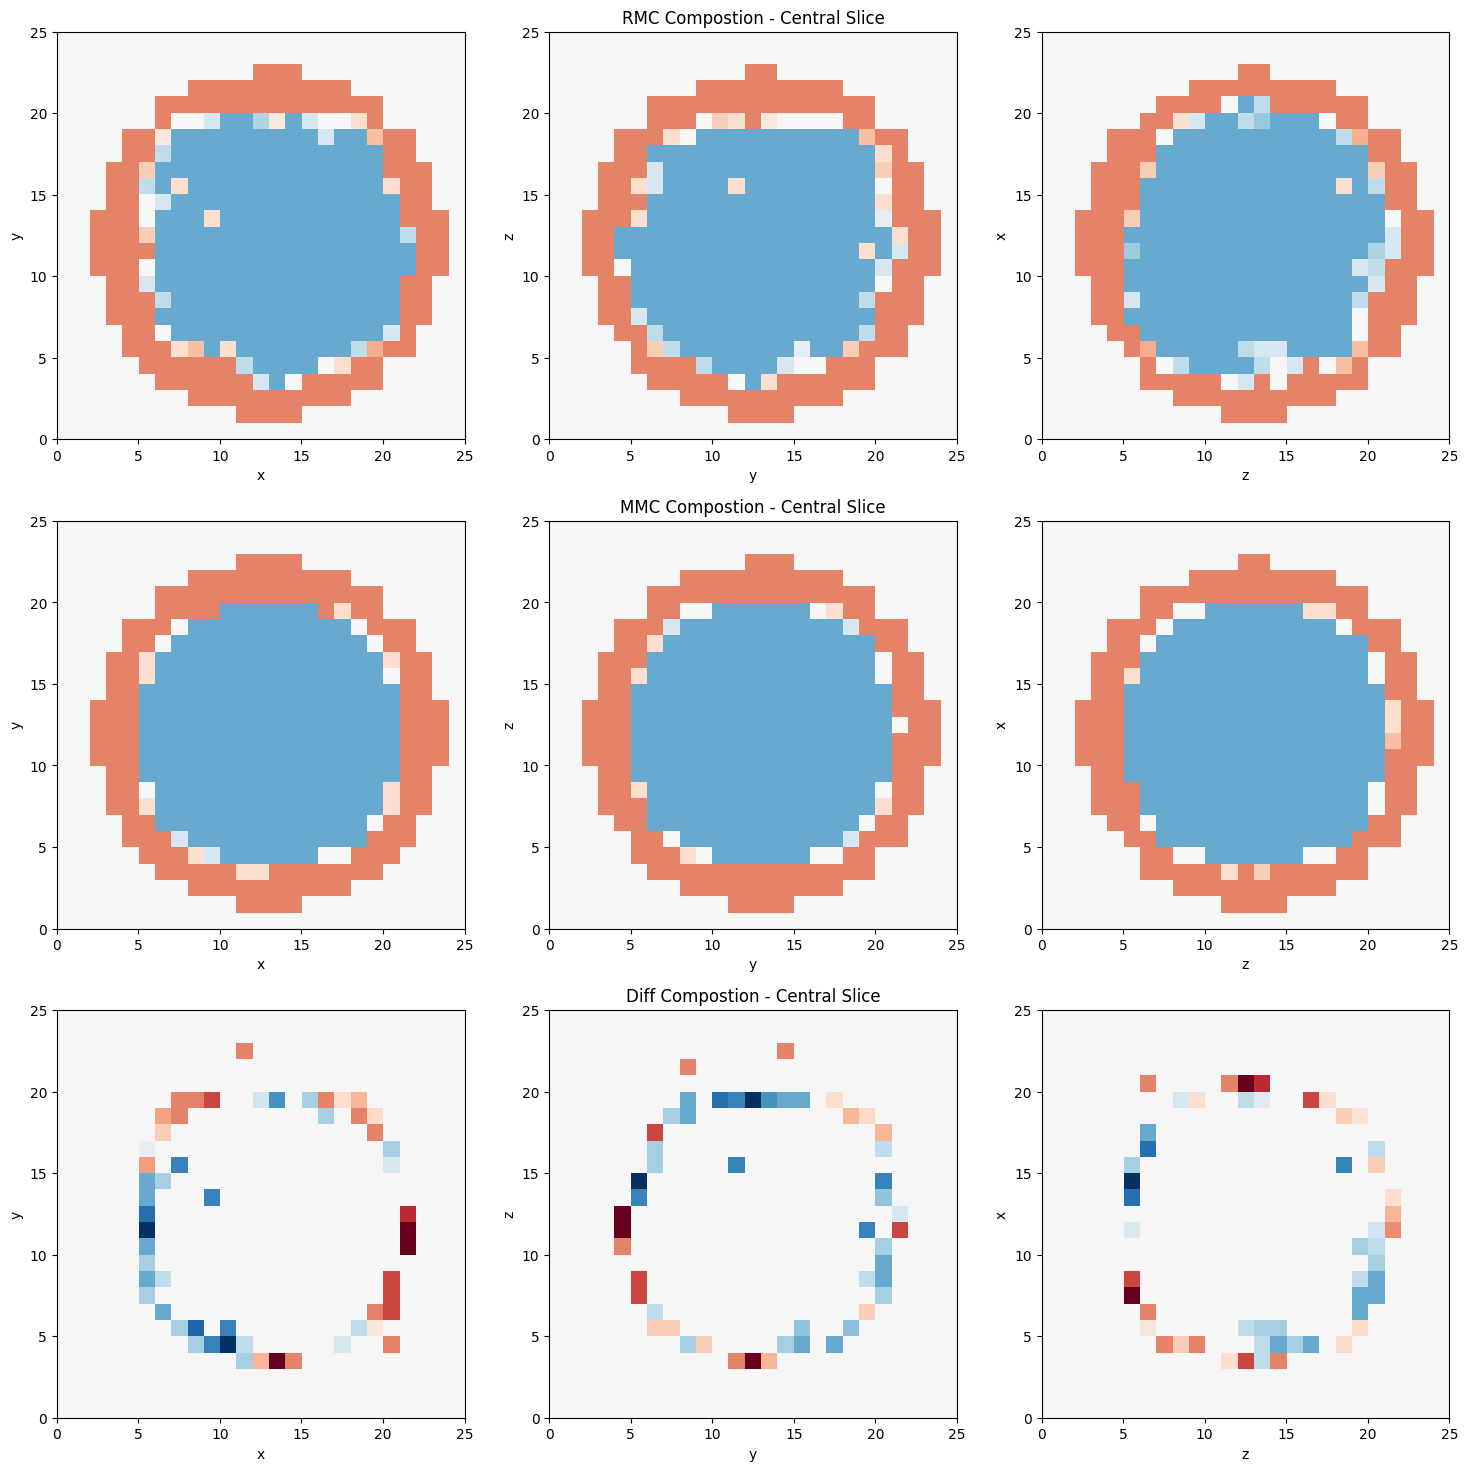

In [51]:
###############################################################################
fig, axs = plt.subplots(3, 3,figsize=(18, 18))
#ax1.set_title("RMC Au Atom Frequency")
axs[0,0].set_xlabel("x")
axs[0,0].set_ylabel("y")
axs[0,0].imshow(RMC_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
axs[0,1].set_title("RMC Compostion - Central Slice")
axs[0,1].set_xlabel("y")
axs[0,1].set_ylabel("z")
axs[0,1].imshow(RMC_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
#ax3.set_title("RMC Au Atom Frequency")
axs[0,2].set_xlabel("z")
axs[0,2].set_ylabel("x")
axs[0,2].imshow(RMC_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[1,0].set_xlabel("x")
axs[1,0].set_ylabel("y")
axs[1,0].imshow(MMC_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
axs[1,1].set_title("MMC Compostion - Central Slice")
axs[1,1].set_xlabel("y")
axs[1,1].set_ylabel("z")
axs[1,1].imshow(MMC_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
#ax3.set_title("MMC Au Atom Frequency")
axs[1,2].set_xlabel("z")
axs[1,2].set_ylabel("x")
axs[1,2].imshow(MMC_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[2,0].set_xlabel("x")
axs[2,0].set_ylabel("y")
axs[2,0].imshow(diff_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
axs[2,1].set_title("Diff Compostion - Central Slice")
axs[2,1].set_xlabel("y")
axs[2,1].set_ylabel("z")
axs[2,1].imshow(diff_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
#ax3.set_title("MMC Au Atom Frequency")
axs[2,2].set_xlabel("z")
axs[2,2].set_ylabel("x")
axs[2,2].imshow(diff_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))